# Восстановление золота из руды

<a id=0></a>
[Содержание](#0)

[1. Описание проекта](#1)

[2. Подготовка данных](#2)

[3. Исследовательский анализ данных](#3)

[4. Обучение модели](#4)

[5. Общий вывод](#5)

<a id=1></a>
## 1. Описание проекта

Компания «Цифры» разрабатывает решения для эффективной работы промышленных предприятий.

**Цель проекта:**

Подготовьте прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Данные:**

Данные с параметрами добычи и очистки находятся в трёх файлах:
- gold_recovery_train_new.csv — обучающая выборка;
- gold_recovery_test_new.csv — тестовая выборка;
- gold_recovery_full_new.csv — исходные данные.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

Данные индексируются датой и временем получения информации (признак `date`).

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

В проекте используем библиотеки `pandas`, `matplotlib` и `sklearn`.

**Технологический процесс:**

- `Rougher feed` — исходное сырье
- `Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
  - `Xanthate` — ксантогенат (промотер, или активатор флотации);
  - `Sulphate` — сульфат (на данном производстве сульфид натрия);
  - `Depressant` — депрессант (силикат натрия).
- `Rougher process` (англ. «грубый процесс») — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота


Параметры этапов:

- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи


Формат наименование признаков:

`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`


Возможные значения для блока (этап):

- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики


Возможные значения для блока (тип_параметра):

- `input` — параметры сырья
- `output` — параметры продукта
- `state` — параметры, характеризующие текущее состояние этапа
- `calculation` — расчётные характеристики

**Метрика качества**

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Метрика sMAPE вычисляется так:

<img src="https://pictures.s3.yandex.net/resources/smape_1576239058.jpg">

Нужно спрогнозировать сразу две величины:

- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

Итоговая метрика складывается из двух величин:

<img src="https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg">

**План работы:**

- Подготовить данные.
- Провести исследовательский анализ данных.
- Построить и обучить модель.
- Написать вывод.

<a id=2></a>
[Содержание](#0)
## 2. Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

RND_STATE = 21012022

Загрузим отдельно каждый датафрейм и посмотрим структуру:

In [2]:
try:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
except:
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [3]:
try:
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
except:
    df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [4]:
try:
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')

df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Посмотрим граничные значения по столбцам:

In [5]:
df_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [6]:
df_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


In [7]:
df_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Посмотрим количество пропусков в процентах и в абсолютных величинах:

In [8]:
# display(pd.DataFrame(round(df_train.isna().mean()*100,)).style.background_gradient('coolwarm'))
def na_info(df):
    na_info = (df.isna() | df.isnull()).sum()
    res = (pd.concat([na_info / df.shape[0], na_info], axis=1,  keys = ['%', 'abs'])
           .sort_values('%', ascending = False))
    return res

na_info(df_train).head(10)

,%,abs
secondary_cleaner.output.tail_sol,0.113436,1605
rougher.state.floatbank10_e_air,0.030815,436
rougher.input.floatbank11_xanthate,0.030249,428
primary_cleaner.output.concentrate_sol,0.020213,286
secondary_cleaner.state.floatbank2_a_air,0.015337,217
final.output.concentrate_sol,0.014913,211
rougher.input.feed_size,0.010177,144
primary_cleaner.input.xanthate,0.007068,100
rougher.input.feed_pb,0.007068,100
final.output.tail_pb,0.007068,100


In [9]:
na_info(df_test).head(10)

,%,abs
rougher.input.floatbank11_xanthate,0.004726,25
rougher.input.feed_sol,0.003970,21
secondary_cleaner.state.floatbank3_a_air,0.001701,9
rougher.input.floatbank11_sulfate,0.001512,8
primary_cleaner.input.depressant,0.000945,5
rougher.input.floatbank10_sulfate,0.000945,5
primary_cleaner.input.xanthate,0.000756,4
primary_cleaner.input.sulfate,0.000756,4
rougher.input.feed_rate,0.000567,3
secondary_cleaner.state.floatbank2_a_air,0.000567,3


In [10]:
na_info(df_full).head(10)

,%,abs
secondary_cleaner.output.tail_sol,0.089922,1748
rougher.input.floatbank11_xanthate,0.023304,453
rougher.state.floatbank10_e_air,0.022429,436
primary_cleaner.output.concentrate_sol,0.019034,370
secondary_cleaner.state.floatbank2_a_air,0.011317,220
final.output.concentrate_sol,0.010854,211
rougher.input.feed_size,0.007459,145
primary_cleaner.output.concentrate_pb,0.005967,116
primary_cleaner.input.xanthate,0.005350,104
final.output.tail_pb,0.005196,101


Пропуски в df_test незначительны, пропусков в df_train больше.

Проверим датафреймы на дубликаты по признаку `date`:

In [11]:
df_train['date'].duplicated().sum()

0

In [12]:
df_test['date'].duplicated().sum()

0

In [13]:
df_full['date'].duplicated().sum()

0

Проиндексируем данные по дате и временем получения информации (признак `date`).

Заполним пропуски значений используя информацию, что соседние по времени параметры часто похожи.

Данные с заполнеными пропусками сохраним в датафремы `good_*`.

In [14]:
df_train.set_index('date', inplace = True)
good_df_train = df_train.ffill(axis = 0)
na_info(good_df_train).head(3)

,%,abs
final.output.concentrate_ag,0.0,0
rougher.state.floatbank10_b_air,0.0,0
rougher.state.floatbank10_f_air,0.0,0


In [15]:
df_test.set_index('date', inplace = True)
good_df_test = df_test.ffill(axis = 0)
na_info(good_df_test).head(3)

,%,abs
primary_cleaner.input.sulfate,0.0,0
primary_cleaner.input.depressant,0.0,0
rougher.state.floatbank10_d_air,0.0,0


In [16]:
df_full.set_index('date', inplace = True)
good_df_full = df_full.ffill(axis = 0)
na_info(good_df_full).head(3)

,%,abs
final.output.concentrate_ag,0.0,0
rougher.state.floatbank10_b_air,0.0,0
rougher.state.floatbank10_f_air,0.0,0


Посмотрим какие признаки есть в good_df_train, но нет в good_df_test:

In [17]:
set(good_df_train.columns) - set(good_df_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В good_df_test нет признаков `.output.`, так как это целевые признаки.

В good_df_test нет признаков `.calculation.` для этапа rougher., видимо эти данные рассчитываются позднее и не доступны во время процесса.

Рассчитаем эффективность обогащения чернового концентрата `rougher.output.recovery` из обучающей выборки.


In [18]:
concentrate_au_column = good_df_train['rougher.output.concentrate_au']
feed_au_column = good_df_train['rougher.input.feed_au']
tail_au_column = good_df_train['rougher.output.tail_au']
input_recovery = good_df_train['rougher.output.recovery']
calc_recovery = concentrate_au_column * (feed_au_column - tail_au_column) / feed_au_column / (concentrate_au_column - tail_au_column) * 100
print('Абсолютная средняя ошибка =', mean_absolute_error(input_recovery, calc_recovery))

Абсолютная средняя ошибка = 1.0748911125799084e-14


MAE имеет очень малое отклонение - это значит, что расчетное значение `rougher.output.recovery` совпадает с данными из столбца.

**Тестовая выборка.**

Отсутствуют столбцы этапов:
- `rougher.output`
- `rougher.calculation`
- `final.output`
- `primary_cleaner.output`
- `secondary_cleaner.output`

Эти данные будут получены по результатам технологического процесса. Это онлайн метрики.

Остальные столбцы исторически известны - значит это офлайн метрики.

**Обучающая выборка.**

Выделим столбцы из тестовой выборки, по которым будет обучаться модель.

Для предсказания `rougher.output.recovery` будут использоватся данные из стобцов этапа rougher.

Для вычисления `final.output.recovery` будут использованы все столбцы из обучающей выборки.


In [19]:
x_columns = good_df_test.columns
rougher_x_columns = set(x_columns[12:34])
final_x_columns = set(x_columns)
display(rougher_x_columns)

{'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level'}

Посмотрим данные в ключевых столбцах в обучающей выборки:

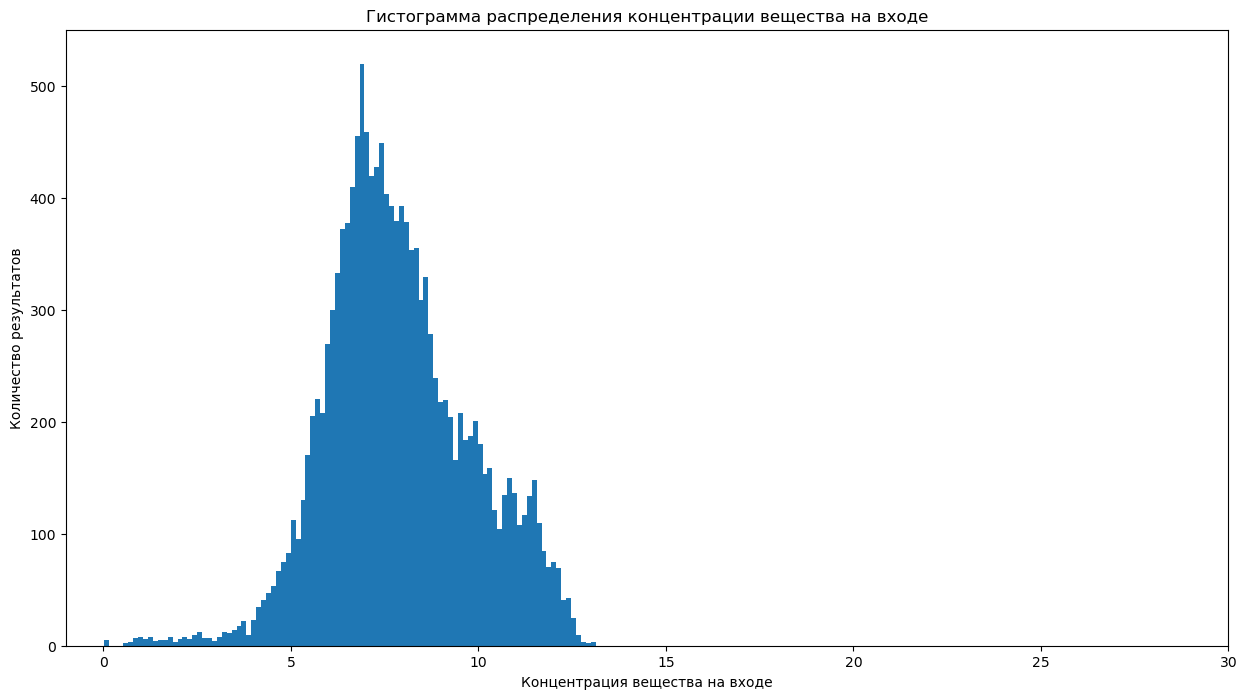

In [20]:
plt.figure(figsize = [15, 8])

plt.hist(good_df_train['rougher.input.feed_au'], bins = 100)

plt.xlim([-1, 30])
plt.ylim([0, 550])

plt.xlabel('Концентрация вещества на входе')
plt.ylabel('Количество результатов')

plt.title('Гистограмма распределения концентрации вещества на входе')
plt.show()

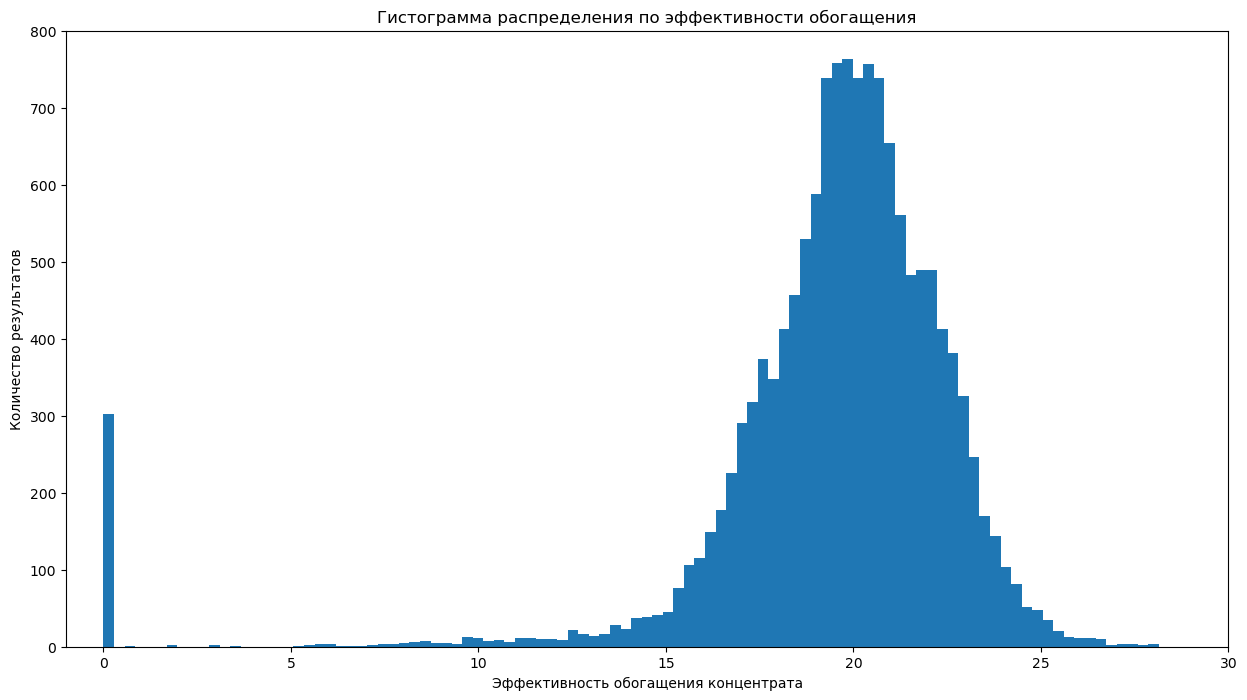

In [21]:
plt.figure(figsize = [15, 8])

plt.hist(good_df_train['rougher.output.concentrate_au'], bins = 100)

plt.xlim([-1, 30])
plt.ylim([0, 800])

plt.xlabel('Эффективность обогащения концентрата')
plt.ylabel('Количество результатов')

plt.title('Гистограмма распределения по эффективности обогащения')
plt.show()

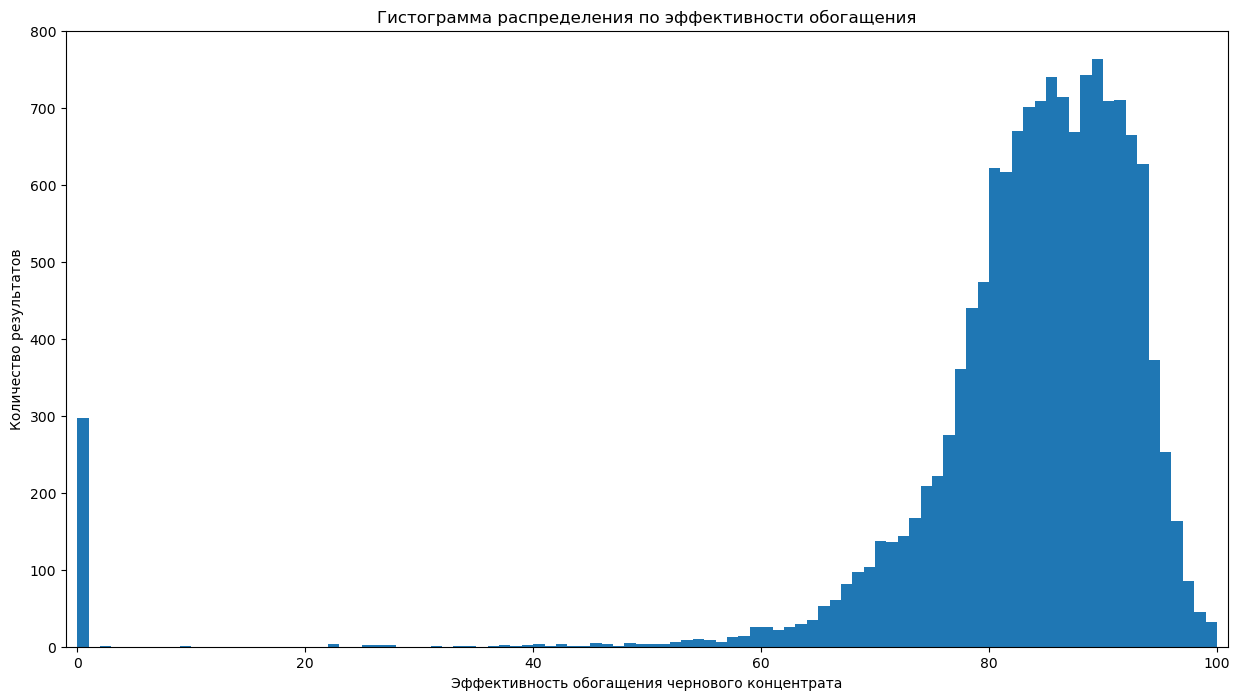

In [22]:
plt.figure(figsize = [15, 8])

plt.hist(good_df_train['rougher.output.recovery'], bins = 100)

plt.xlim([-1, 101])
plt.ylim([0, 800])

plt.xlabel('Эффективность обогащения чернового концентрата')
plt.ylabel('Количество результатов')

plt.title('Гистограмма распределения по эффективности обогащения')
plt.show()

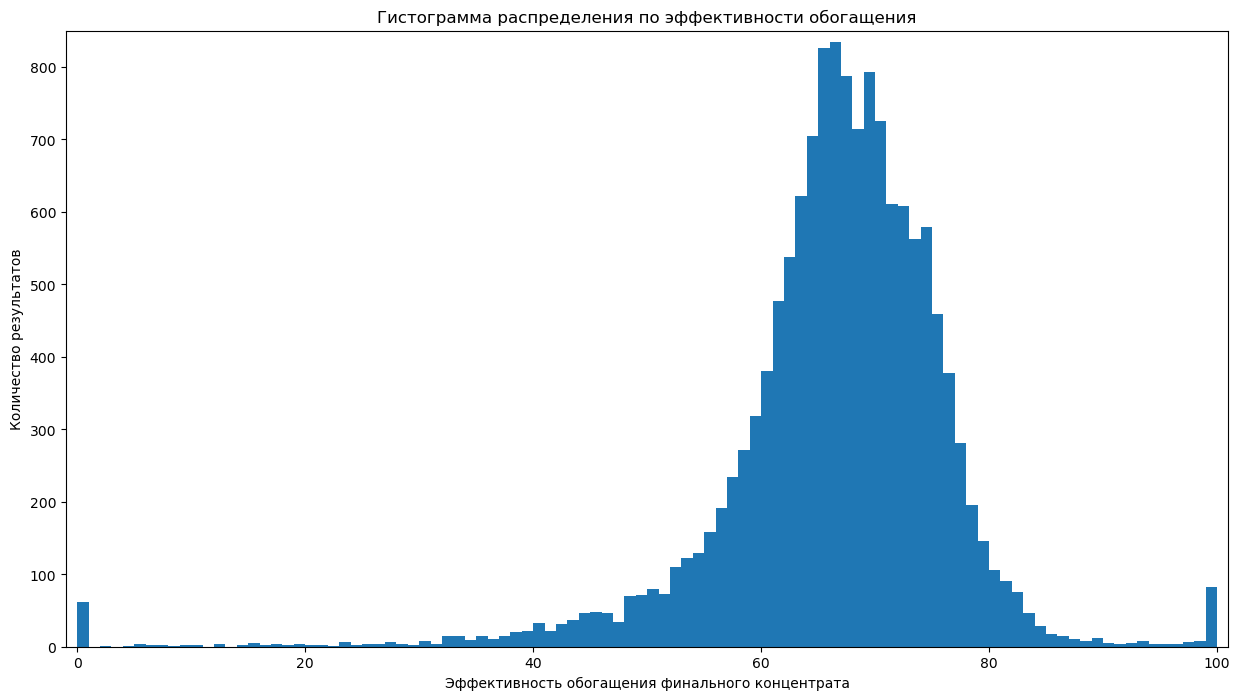

In [23]:
plt.figure(figsize = [15, 8])

plt.hist(good_df_train['final.output.recovery'], bins = 100)

plt.xlim([-1, 101])
plt.ylim([0, 850])

plt.xlabel('Эффективность обогащения финального концентрата')
plt.ylabel('Количество результатов')

plt.title('Гистограмма распределения по эффективности обогащения')
plt.show()

Строки с нулевыми значениями можно считать аномалией.

Удалим их, так как они могут исказить обучающие данные:

In [24]:
good_df_train = good_df_train.drop(good_df_train[good_df_train['rougher.input.feed_au'] == 0].index)
good_df_train[good_df_train['rougher.input.feed_au'] == 0]['rougher.input.feed_au'].count()

0

In [25]:
good_df_train = good_df_train.drop(good_df_train[good_df_train['rougher.output.recovery'] == 0].index)
good_df_train[good_df_train['rougher.output.recovery'] == 0]['rougher.output.recovery'].count()

0

In [26]:
good_df_train = good_df_train.drop(good_df_train[good_df_train['rougher.output.concentrate_au'] == 0].index)
good_df_train[good_df_train['rougher.output.concentrate_au'] == 0]['rougher.output.concentrate_au'].count()


0

In [27]:
good_df_train = good_df_train.drop(good_df_train[good_df_train['final.output.recovery'] == 0].index)
good_df_train[good_df_train['final.output.recovery'] == 0]['final.output.recovery'].count()

0

Проверим, есть ли нулевые значения в признаках:
- `primary_cleaner.output.concentrate_au`
- `secondary_cleaner.output.concentrate_au`

In [28]:
good_df_train[good_df_train['primary_cleaner.output.concentrate_au'] == 0]['primary_cleaner.output.concentrate_au'].count()

70

In [29]:
good_df_train[good_df_train['secondary_cleaner.output.tail_au'] == 0]['secondary_cleaner.output.tail_au'].count()

707

По данным этапам тоже присутвуют нулевые значения. Но так как они не являются целью модели и не входят в список столбцов обучающей модели, оставим их без изменения.

**Вывод:**

В данных присутвовали аномалии:

- Пропущенные значения;
- Нулевые значения на ключевых этапах.

Неподходящие данные были удалены. Возможно не были сняты данные по выбранным этапам или они еще не были получены в результате работы системы.

Данные готовы к дальнейшему анализу.

<a id=3></a>
[Содержание](#0)
## 3. Исследовательский анализ данных

Рассмотрим концентрацию веществ на каждом этапе:

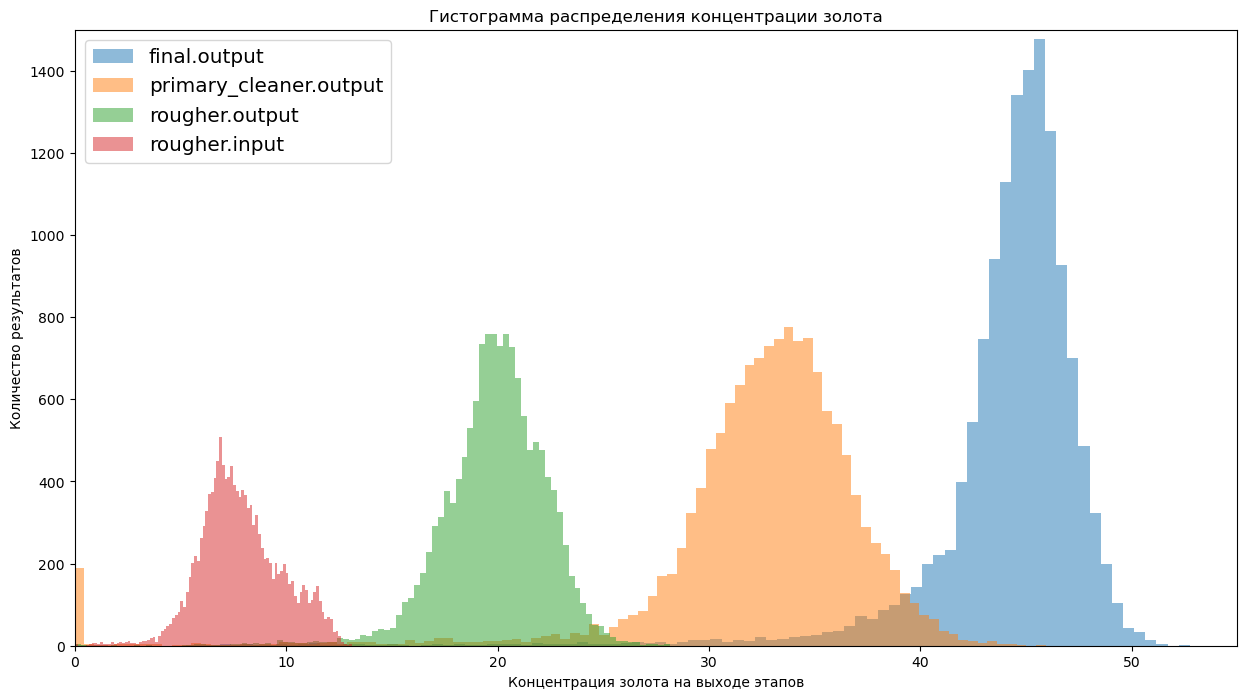

In [30]:
plt.figure(figsize = [15, 8])

plt.hist(good_df_train['final.output.concentrate_au'], bins = 100, label = 'final.output', alpha = .5)
plt.hist(good_df_train['primary_cleaner.output.concentrate_au'], bins = 100, label = 'primary_cleaner.output', alpha = .5)
plt.hist(good_df_train['rougher.output.concentrate_au'], bins = 100, label = 'rougher.output', alpha = .5)
plt.hist(good_df_train['rougher.input.feed_au'], bins = 100, label = 'rougher.input', alpha = .5)

plt.xlim([0, 55])
plt.ylim([0, 1500])

plt.xlabel('Концентрация золота на выходе этапов')
plt.ylabel('Количество результатов')

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title('Гистограмма распределения концентрации золота')
plt.show()

Концентрация золота повышается с каждым этапом. Цель флотации и очисток увеличить концентрацию золота.

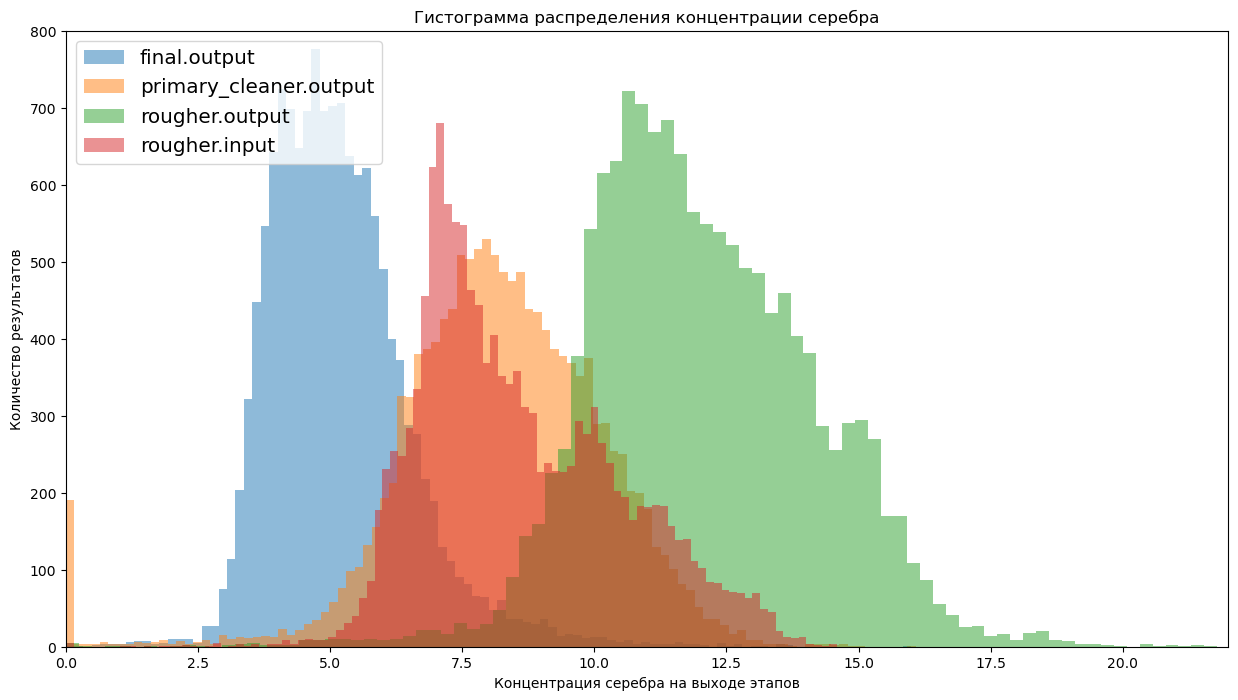

In [31]:
plt.figure(figsize = [15, 8])

plt.hist(good_df_train['final.output.concentrate_ag'], bins = 100, label = 'final.output', alpha = .5)
plt.hist(good_df_train['primary_cleaner.output.concentrate_ag'], bins = 100, label = 'primary_cleaner.output', alpha = .5)
plt.hist(good_df_train['rougher.output.concentrate_ag'], bins = 100, label = 'rougher.output', alpha = .5)
plt.hist(good_df_train['rougher.input.feed_ag'], bins = 100, label = 'rougher.input', alpha = .5)

plt.xlim([0, 22])
plt.ylim([0, 800])

plt.xlabel('Концентрация серебра на выходе этапов')
plt.ylabel('Количество результатов')

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title('Гистограмма распределения концентрации серебра')
plt.show()

Концентрация серебра понижается с каждым шагом очистки. Так как основным благородным металом является золото, то остальные металлы и соединения должны быть отфильтрованы.

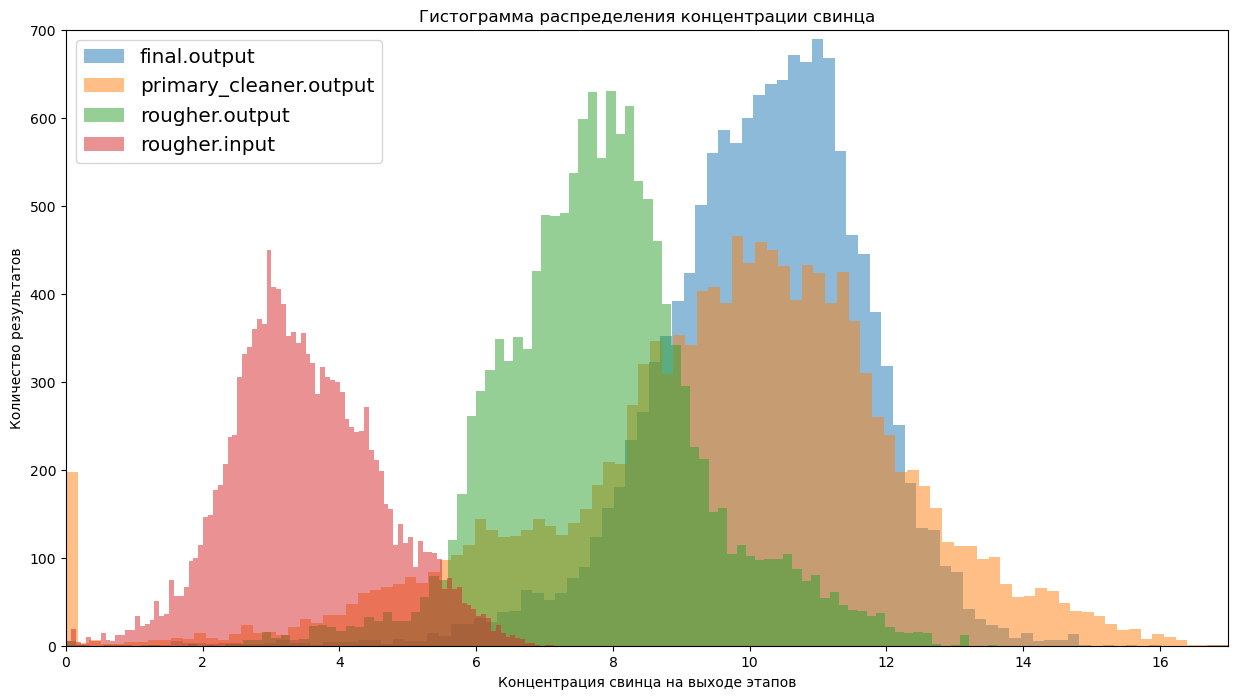

In [32]:
plt.figure(figsize = [15, 8])

plt.hist(good_df_train['final.output.concentrate_pb'], bins = 100, label = 'final.output', alpha = .5)
plt.hist(good_df_train['primary_cleaner.output.concentrate_pb'], bins = 100, label = 'primary_cleaner.output', alpha = .5)
plt.hist(good_df_train['rougher.output.concentrate_pb'], bins = 100, label = 'rougher.output', alpha = .5)
plt.hist(good_df_train['rougher.input.feed_pb'], bins = 100, label = 'rougher.input', alpha=  .5)

plt.xlim([0, 17])
plt.ylim([0, 700])

plt.xlabel('Концентрация свинца на выходе этапов')
plt.ylabel('Количество результатов')

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title('Гистограмма распределения концентрации свинца')
plt.show()

Концентрация свинца повышается с этапа rougher до primary_cleaner, а потом усредняется. Это связано с химическим процесами очищения золота. При использование азотнокислого выщелачивания в концентрате образуется много сульфата свинца. Повышение концентрации свинца в целом происходит не только из-за этого процесса, но из-за очищения других составляющих из золотоносной руды.

Изучим размеры сырья на этапах обработки.

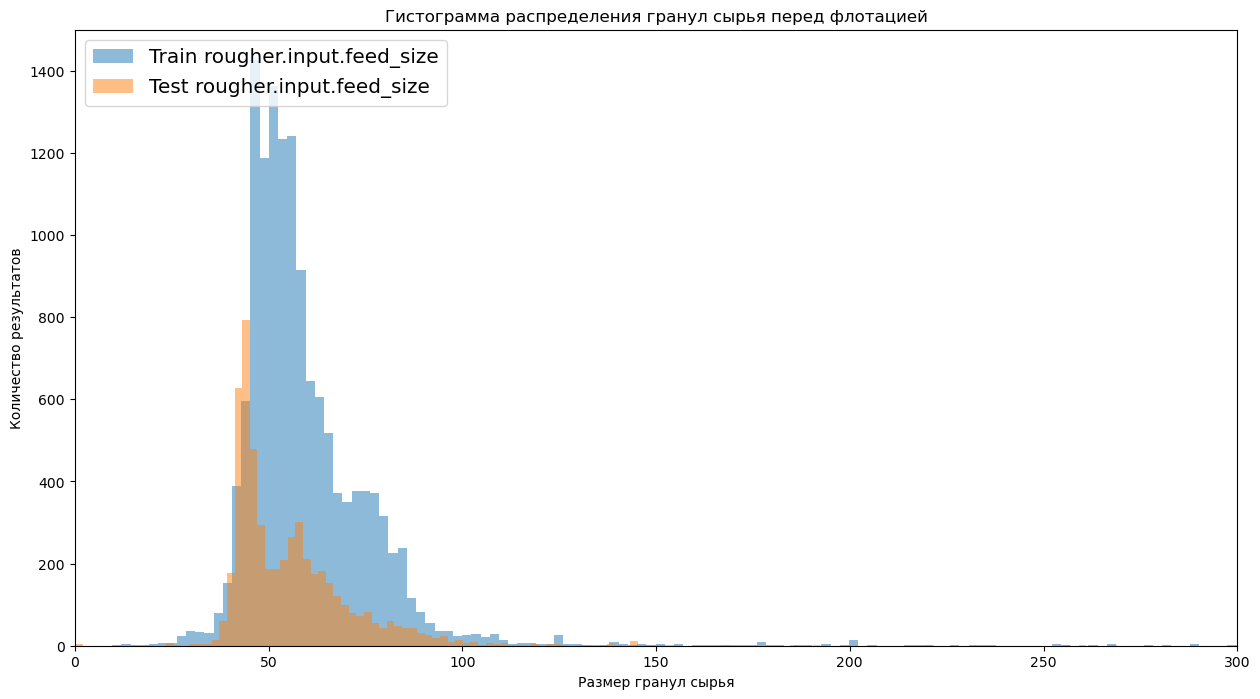

In [33]:
plt.figure(figsize = [15, 8])

plt.hist(good_df_train['rougher.input.feed_size'], bins = 200, label = 'Train rougher.input.feed_size', alpha = .5)
plt.hist(good_df_test['rougher.input.feed_size'], bins = 200, label = 'Test rougher.input.feed_size', alpha = .5)

plt.xlim([0, 300])
plt.ylim([0, 1500])

plt.xlabel('Размер гранул сырья')
plt.ylabel('Количество результатов')

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title('Гистограмма распределения гранул сырья перед флотацией')
plt.show()

Распределение гранул до флотации похоже на нормальное со смещением влево как в обучающей, так и в тестовой выбрке. Существует много выбросов после размера гранул 100.

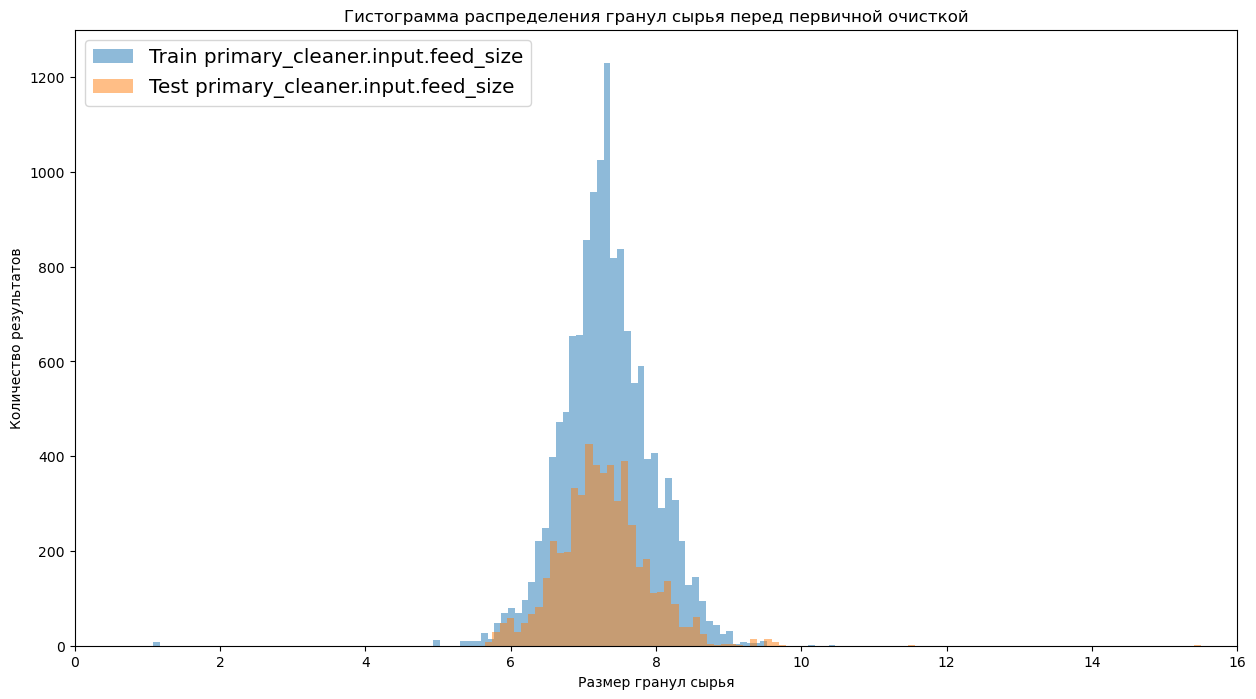

In [34]:
plt.figure(figsize = [15, 8])

plt.hist(good_df_train['primary_cleaner.input.feed_size'], bins = 100, label = 'Train primary_cleaner.input.feed_size', alpha = .5)
plt.hist(good_df_test['primary_cleaner.input.feed_size'], bins = 100, label = 'Test primary_cleaner.input.feed_size', alpha = .5)

plt.xlim([0, 16])
plt.ylim([0, 1300])

plt.xlabel('Размер гранул сырья')
plt.ylabel('Количество результатов')

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title('Гистограмма распределения гранул сырья перед первичной очисткой')
plt.show()

Размеры гранул перед первичной очисткой обладают нормальным распределением.

Подготовим столбцы с финальными концентрациями в обучающей выборке.

In [35]:
final_output_concentrate_sum = (good_df_train['final.output.concentrate_au'] + 
                                good_df_train['final.output.concentrate_ag'] + 
                                good_df_train['final.output.concentrate_pb'] +
                                good_df_train['final.output.concentrate_sol'])

primary_cleaner_output_concentrate_sum = (good_df_train['primary_cleaner.output.concentrate_au'] + 
                                          good_df_train['primary_cleaner.output.concentrate_ag'] + 
                                          good_df_train['primary_cleaner.output.concentrate_pb'] +
                                          good_df_train['primary_cleaner.output.concentrate_sol'])

rougher_output_concentrate_sum = (good_df_train['rougher.output.concentrate_au'] + 
                                  good_df_train['rougher.output.concentrate_ag'] + 
                                  good_df_train['rougher.output.concentrate_pb'] +
                                  good_df_train['rougher.output.concentrate_sol'])

rougher_input_feed_sum = (good_df_train['rougher.input.feed_au'] + 
                          good_df_train['rougher.input.feed_ag'] + 
                          good_df_train['rougher.input.feed_pb'] +
                          good_df_train['rougher.input.feed_sol'])

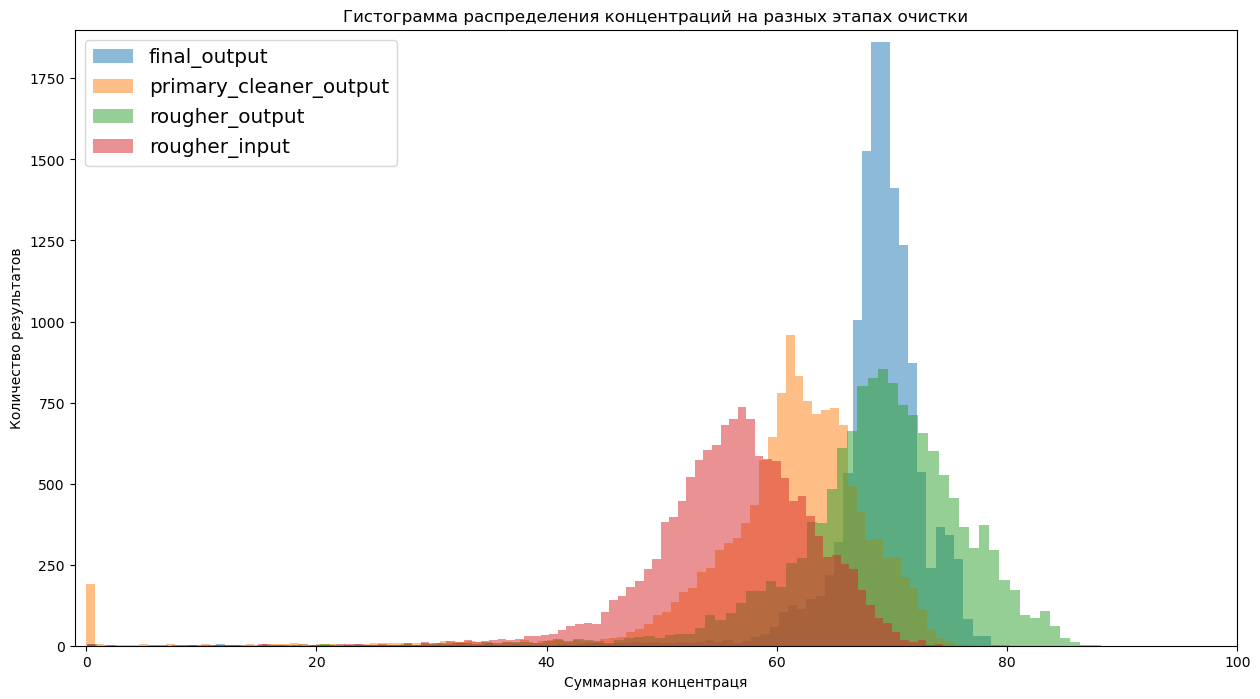

In [36]:
plt.figure(figsize = [15, 8])

plt.hist(final_output_concentrate_sum, bins = 100, label = 'final_output', alpha = .5)
plt.hist(primary_cleaner_output_concentrate_sum, bins = 100, label = 'primary_cleaner_output', alpha = .5)
plt.hist(rougher_output_concentrate_sum, bins = 100, label = 'rougher_output', alpha = .5)
plt.hist(rougher_input_feed_sum, bins = 100, label = 'rougher_input', alpha = .5)

plt.xlim([-1, 100])
plt.ylim([0, 1900])

plt.xlabel('Суммарная концентраця')
plt.ylabel('Количество результатов')

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title('Гистограмма распределения концентраций на разных этапах очистки')
plt.show()

По графику видно, что из аномалий много значений в 0. Приблизим график.

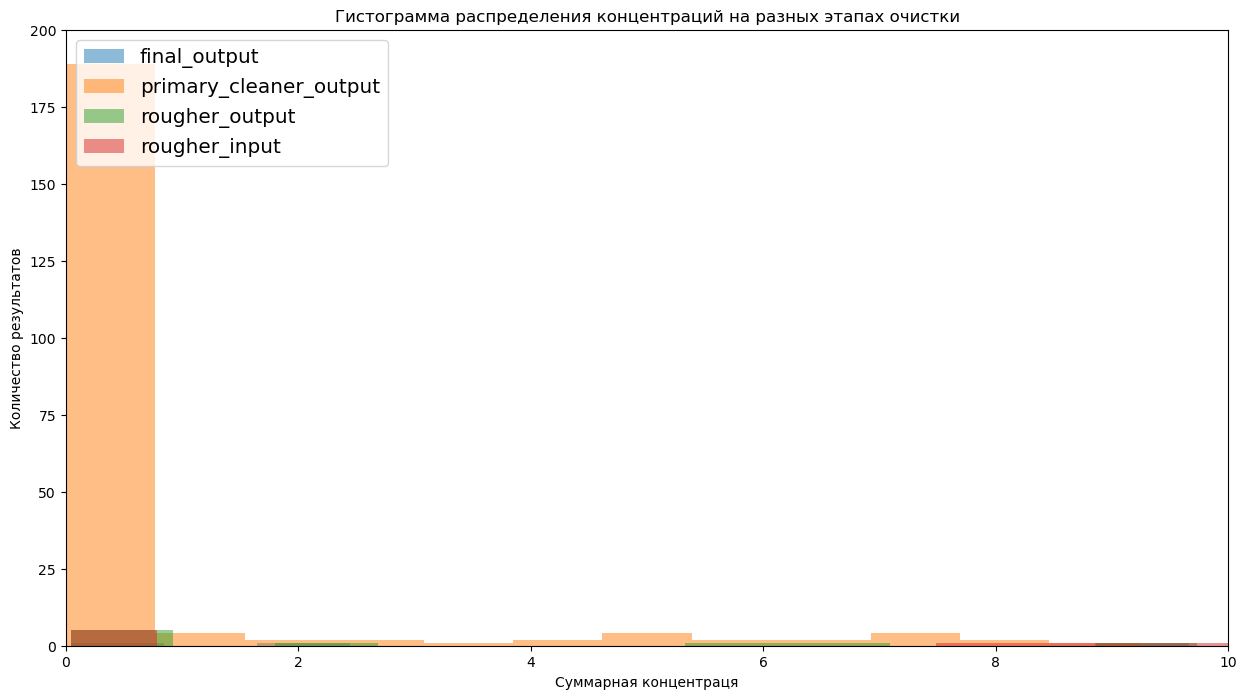

In [37]:
plt.figure(figsize=[15, 8])

plt.hist(final_output_concentrate_sum, bins = 100, label = 'final_output', alpha = .5)
plt.hist(primary_cleaner_output_concentrate_sum, bins = 100, label = 'primary_cleaner_output', alpha = .5)
plt.hist(rougher_output_concentrate_sum, bins = 100, label = 'rougher_output', alpha = .5)
plt.hist(rougher_input_feed_sum, bins = 100, label = 'rougher_input', alpha = .5)

plt.xlim([0, 10])
plt.ylim([0, 200])

plt.xlabel('Суммарная концентраця')
plt.ylabel('Количество результатов')

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title('Гистограмма распределения концентраций на разных этапах очистки')
plt.show()

На этапе предобрабоки были найдены строки с нулевыми значениями, они являются аномалией. Удалим их.

In [38]:
good_df_train = good_df_train.drop(good_df_train[good_df_train['rougher.input.feed_au'] == 0].index)
good_df_train = good_df_train.drop(good_df_train[good_df_train['rougher.input.feed_ag'] == 0].index)
good_df_train = good_df_train.drop(good_df_train[good_df_train['rougher.input.feed_pb'] == 0].index)
good_df_train = good_df_train.drop(good_df_train[good_df_train['rougher.input.feed_sol'] == 0].index)

good_df_train[good_df_train['rougher.input.feed_au'] == 0]['rougher.input.feed_au'].count()

0

In [39]:
good_df_train = good_df_train.drop(good_df_train[good_df_train['primary_cleaner.output.concentrate_au'] == 0].index)
good_df_train = good_df_train.drop(good_df_train[good_df_train['primary_cleaner.output.concentrate_ag'] == 0].index)
good_df_train = good_df_train.drop(good_df_train[good_df_train['primary_cleaner.output.concentrate_pb'] == 0].index)
good_df_train = good_df_train.drop(good_df_train[good_df_train['primary_cleaner.output.concentrate_sol'] == 0].index)

good_df_train[good_df_train['primary_cleaner.output.concentrate_au'] == 0]['primary_cleaner.output.concentrate_au'].count()

0

**Вывод:**

В результате анализа были изучены:

- Концетрации основных веществ на разных этапах очистки.
- Размер гранул тестовой и обучающей выборки.
- Суммарная концентрация веществ.

Аномалии были удалены. Данные готовы к обучению.

<a id=4></a>
[Содержание](#0)
## 4. Обучение модели

Создадим разделение признаков для предсказания `rougher.output.recovery` и `final.output.recovery`.

Подготовим признаки для `final.output.recovery`:

In [40]:
columns_to_delete = set(good_df_train.columns) - final_x_columns
train_x_final = good_df_train.drop(columns_to_delete, axis = 1)

Проверим вхождения всех столбцов из train_x_final в столбцах тестовой выборки df_test:

In [41]:
print(set(train_x_final.columns) - set(df_test.columns))

set()


Подготовим признаки для `rougher.output.recovery`:

In [42]:
columns_to_delete = set(train_x_final.columns) - rougher_x_columns
train_x_rougher = train_x_final.drop(columns_to_delete, axis = 1)

Подготовим целевые признаки для тренировочных данных:

In [43]:
train_y_final = good_df_train['final.output.recovery']
train_y_rougher = good_df_train['rougher.output.recovery']

Подготовим признаки тестовой выборки:

In [44]:
test_x_final = good_df_test

In [45]:
columns_to_delete = set(test_x_final.columns) - rougher_x_columns
test_x_rougher = test_x_final.drop(columns_to_delete, axis = 1)

В тестовой выборке отсутствуют целевые признаки для моделей `rougher.output.recovery`, `final.output.recovery`.

Это фактические даные, которые мы можем получить только по факту реальных измерений.

Для обучения модели и проверки ее качества оценки добавим поля `rougher.output.recovery`, `final.output.recovery`
в тестовый датафрейм.

In [46]:
test_x_final = test_x_final.merge(df_full[['final.output.recovery', 'rougher.output.recovery']],
                                           how = 'left', on = 'date')

Подготовим целевые признаки для тестовых данных.

Выделяем целевые признаки:

In [47]:
test_y_final = test_x_final['final.output.recovery']
test_y_rougher = test_x_final['rougher.output.recovery']

Удалим целевые признаки из обучающих тестовых данных:

In [48]:
test_x_final = test_x_final.drop(['final.output.recovery', 'rougher.output.recovery'], axis = 1)
display(test_x_final.columns)

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

Напишем функцию вычисления симметричного среднего абсолютного процентного отклонения:

In [49]:
def sMAPE(real, predicted):
    n = real.shape[0]
    sMAPE = ((2 * abs(real - predicted)/
             (abs(real) + abs(predicted))).sum() * 100 / n)
    return sMAPE

In [50]:
def sMAPE_score(sMAPE_rougher, sMAPE_final):
    return sMAPE_rougher * 0.25 + sMAPE_final * 0.75

Перед нами стоит задача регресии. Выберем следующие модели для обучения:

- LinearRegression
- DecisionTreeRegressor
- Ridge
- RandomForestRegressor

Выполним поиск лучшей модели для предсказаний.

Подберем гиперпараметры для модели LinearRegression:

In [51]:
%%time

model = LinearRegression() 
hyperparams = [{'fit_intercept': [True, False]}]

print('# Подбор гиперпараметров для LinearRegression, rougher')
grid = GridSearchCV(model, hyperparams, scoring = make_scorer(sMAPE, greater_is_better = False))
grid.fit(train_x_rougher, train_y_rougher)
sMAPE_rougher = grid.best_score_
print('Лучший целевой показатель sMAPE:', sMAPE_rougher)
print('Лучший набор параметров:', grid.best_params_)

# Подбор гиперпараметров для LinearRegression, rougher
Лучший целевой показатель sMAPE: -6.6733523947009035
Лучший набор параметров: {'fit_intercept': True}
CPU times: user 676 ms, sys: 245 ms, total: 922 ms
Wall time: 107 ms


In [52]:
%%time

print('# Подбор гиперпараметров для LinearRegression, final')
grid = GridSearchCV(model, hyperparams, scoring = make_scorer(sMAPE, greater_is_better = False))
grid.fit(train_x_final, train_y_final)
sMAPE_final = grid.best_score_
print('Лучший целевой показатель sMAPE:', sMAPE_final)
print('Лучший набор параметров:', grid.best_params_)

# Подбор гиперпараметров для LinearRegression, final
Лучший целевой показатель sMAPE: -10.931827683874731
Лучший набор параметров: {'fit_intercept': False}
CPU times: user 1.26 s, sys: 483 ms, total: 1.74 s
Wall time: 184 ms


In [53]:
print('Для LinearRegression sMAPE:', sMAPE_score(sMAPE_rougher, sMAPE_final))

Для LinearRegression sMAPE: -9.867208861581275


Подберем гиперпараметры для модели Ridge:

In [54]:
%%time

model = Ridge(random_state = RND_STATE) 
hyperparams = [{'alpha':[0.1, 1, 10, 50, 100],
                'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']}]

print('# Подбор гиперпараметров для Ridge, rougher')
grid = GridSearchCV(model, hyperparams, scoring = make_scorer(sMAPE, greater_is_better = False))
grid.fit(train_x_rougher, train_y_rougher)
sMAPE_rougher = grid.best_score_
print('Лучший целевой показатель sMAPE:', sMAPE_rougher)
print('Лучший набор параметров:', grid.best_params_)

# Подбор гиперпараметров для Ridge, rougher
Лучший целевой показатель sMAPE: -6.366706795558127
Лучший набор параметров: {'alpha': 10, 'solver': 'sparse_cg'}
CPU times: user 5.21 s, sys: 1.42 s, total: 6.64 s
Wall time: 693 ms


In [55]:
%%time

print('# Подбор гиперпараметров для Ridge, final')
grid = GridSearchCV(model, hyperparams, scoring = make_scorer(sMAPE, greater_is_better = False))
grid.fit(train_x_final, train_y_final)
sMAPE_final = grid.best_score_
print('Лучший целевой показатель sMAPE:', sMAPE_final)
print('Лучший набор параметров:', grid.best_params_)

# Подбор гиперпараметров для Ridge, final
Лучший целевой показатель sMAPE: -10.617293116980278
Лучший набор параметров: {'alpha': 50, 'solver': 'sparse_cg'}
CPU times: user 15.4 s, sys: 1.86 s, total: 17.3 s
Wall time: 1.82 s


In [56]:
print('Для Ridge sMAPE:', sMAPE_score(sMAPE_rougher, sMAPE_final))

Для Ridge sMAPE: -9.554646536624741


Подберем гиперпараметры для модели RandomForestRegressor (Wall time: 42min):

In [57]:
%%time

model = RandomForestRegressor(random_state = RND_STATE) 
hyperparams = [{'n_estimators':[50, 100, 150, 200],
                'max_depth': range(1, 11, 1),
                'min_samples_leaf': [ 1, 2],
                'random_state':[RND_STATE]}]

print('# Подбор гиперпараметров для RandomForestRegressor, rougher')
grid = GridSearchCV(model, hyperparams, scoring = make_scorer(sMAPE, greater_is_better = False))
grid.fit(train_x_rougher, train_y_rougher)
sMAPE_rougher = grid.best_score_
print('Лучший целевой показатель sMAPE:', sMAPE_rougher)
print('Лучший набор параметров:', grid.best_params_)

# Подбор гиперпараметров для RandomForestRegressor, rougher
Лучший целевой показатель sMAPE: -6.6165335020808245
Лучший набор параметров: {'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 21012022}
CPU times: user 40min 22s, sys: 8.7 s, total: 40min 30s
Wall time: 40min 29s


In [58]:
%%time

print('# Подбор гиперпараметров для RandomForestRegressor, final')
grid = GridSearchCV(model, hyperparams, scoring = make_scorer(sMAPE, greater_is_better = False))
grid.fit(train_x_final, train_y_final)
sMAPE_final = grid.best_score_
print('Лучший целевой показатель sMAPE:', sMAPE_final)
print('Лучший набор параметров:', grid.best_params_)

# Подбор гиперпараметров для RandomForestRegressor, final
Лучший целевой показатель sMAPE: -8.999516408674019
Лучший набор параметров: {'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 150, 'random_state': 21012022}
CPU times: user 1h 36min 3s, sys: 12.2 s, total: 1h 36min 15s
Wall time: 1h 36min 15s


In [59]:
print('Для RandomForestRegressor sMAPE:', sMAPE_score(sMAPE_rougher, sMAPE_final))

Для RandomForestRegressor sMAPE: -8.403770682025721


Подберем гиперпараметры для модели DecisionTreeRegressor (Wall time: 47min):

In [60]:
%%time

model = DecisionTreeRegressor(random_state = RND_STATE) 
hyperparams = [{'criterion':['mse', 'mae'],
                'max_depth':range(1, 11, 1),
                'min_samples_leaf': [ 1, 2],
                'random_state':[RND_STATE]}]

print('# Подбор гиперпараметров DecisionTreeRegressor, rougher')
grid = GridSearchCV(model, hyperparams, scoring = make_scorer(sMAPE, greater_is_better = False))
grid.fit(train_x_rougher, train_y_rougher)
sMAPE_rougher = grid.best_score_
print('Лучший целевой показатель sMAPE:', sMAPE_rougher)
print('Лучший набор параметров:', grid.best_params_)

# Подбор гиперпараметров DecisionTreeRegressor, rougher
Лучший целевой показатель sMAPE: -6.948684347216822
Лучший набор параметров: {'criterion': 'mse', 'max_depth': 5, 'min_samples_leaf': 2, 'random_state': 21012022}
CPU times: user 19min 8s, sys: 2.03 s, total: 19min 10s
Wall time: 19min 10s


In [61]:
%%time

print('# Подбор гиперпараметров DecisionTreeRegressor, final')
grid = GridSearchCV(model, hyperparams, scoring = make_scorer(sMAPE, greater_is_better = False))
grid.fit(train_x_final, train_y_final)
sMAPE_final = grid.best_score_
print('Лучший целевой показатель sMAPE:', sMAPE_final)
print('Лучший набор параметров:', grid.best_params_)

# Подбор гиперпараметров DecisionTreeRegressor, final
Лучший целевой показатель sMAPE: -9.428724821280621
Лучший набор параметров: {'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 1, 'random_state': 21012022}
CPU times: user 46min 47s, sys: 4.91 s, total: 46min 52s
Wall time: 46min 52s


In [62]:
print('Для DecisionTreeRegressor sMAPE:', sMAPE_score(sMAPE_rougher, sMAPE_final))

Для DecisionTreeRegressor sMAPE: -8.808714702764672


На данный момент для дальнешего прогнозирования выбираем модель RandomForestRegressor с параметрами:

для `rougher`
- n_estimators = 200,
- max_depth = 4,
- min_samples_leaf = 1

для `final`
- n_estimators = 150,
- max_depth = 4,
- min_samples_leaf = 2

Эти параметры позволяют получить итоговый показатель sMAPE = 8.4

In [63]:
%%time

model = RandomForestRegressor(n_estimators = 200, max_depth = 4, min_samples_leaf = 1, random_state = RND_STATE) 
model.fit(train_x_rougher, train_y_rougher)
predicted_rougher = model.predict(test_x_rougher)
sMAPE_rougher = sMAPE(test_y_rougher, predicted_rougher)

model = RandomForestRegressor(n_estimators = 150, max_depth = 4, min_samples_leaf = 2, random_state = RND_STATE) 
model.fit(train_x_final, train_y_final)
predicted_final = model.predict(test_x_final)
sMAPE_final = sMAPE(test_y_final, predicted_final)

print('Для тестовых данных RandomForestRegressor sMAPE:', sMAPE_score(sMAPE_rougher, sMAPE_final))

Для тестовых данных RandomForestRegressor sMAPE: 9.435815339604162
CPU times: user 26.9 s, sys: 53.7 ms, total: 26.9 s
Wall time: 26.9 s


Создадим константную модель из медианных значений:

In [64]:
median_rougher = good_df_full['rougher.output.recovery'].median()
median_final = good_df_full['final.output.recovery'].median()

sMAPE_rougher = sMAPE(test_y_rougher, median_rougher)
sMAPE_final = sMAPE(test_y_final, median_final)
print('Для медианной константной модели sMAPE', sMAPE_score(sMAPE_rougher, sMAPE_final))

Для медианной константной модели sMAPE 9.165307584396805


**Вывод:**

Была написана функция для вычисления sMAPE.

Каждая модель была изучена на качество методом поиска по сетке и подбором гиперпараметров.

Была отобрана лучшая модель - RandomForestRegressor, ее значение sMAPE самое низкое 8.4.
На тестовых данных модель RandomForestRegressor показала значение sMAPE = 9.435, что хуже медианной константной модели sMAPE = 9.165.

<a id=5></a>
[Содержание](#0)
## 5. Общий вывод

В ходе работы было выполнено:

- Подготовлены данные.
- Проведен исследовательский анализ данных.
- Построена и обучена модель.

Основные сложности:
- Большое кол-во столбцов в данных;
- Скорость подбора по сетке с поиском лучших гиперпараметров.

Модель RandomForestRegressor показала лучшее значение sMAPE = 9.435, но она проигрывает константной модели sMAPE = 9.165.